In [2]:
%matplotlib widget
import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import NA_N9916A
import time
from scipy.optimize import curve_fit

import sys 
sys.path.insert(1, 'C:\\Users\\oper\\SynologyDrive\\Lab2023\\Qubit\\QTLab2324\\PAandQubit\\Exercises_data')
from FunFit import *

In [4]:

# -26 dB
# 10 MHz di span
###############################

f_min = 7.415
f_max = 7.418
    
ip          = '192.168.40.10'   
mode        = 'NA'              
s_par       = 'S21'       
f_center = (f_min + f_max)*1e9/2
f_span = (f_max - f_min)*1e9   
n_pts = 500
hdf5_file   = '2024-04-18.hdf5'     

n_pts = 600


                            
###############################


vna = NA_N9916A.N9916A(ip)
vna.set_num_pts(n_pts)

N9916A:	Connection successful!


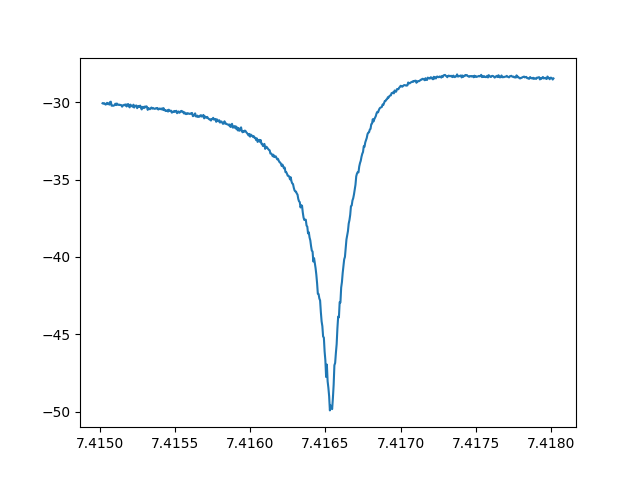

In [7]:
vna.set_mode('NA')
vna.set_NA_par('S21')
sweep = vna.get_data()
sweep['Num pts'] = n_pts
sweep['Span'] = f_span

f, I, Q, a, b = sweep.values()
amp = 10*np.log10(I**2 + Q**2) # amplitude

plt.clf()
plt.plot(f, amp)
plt.show()

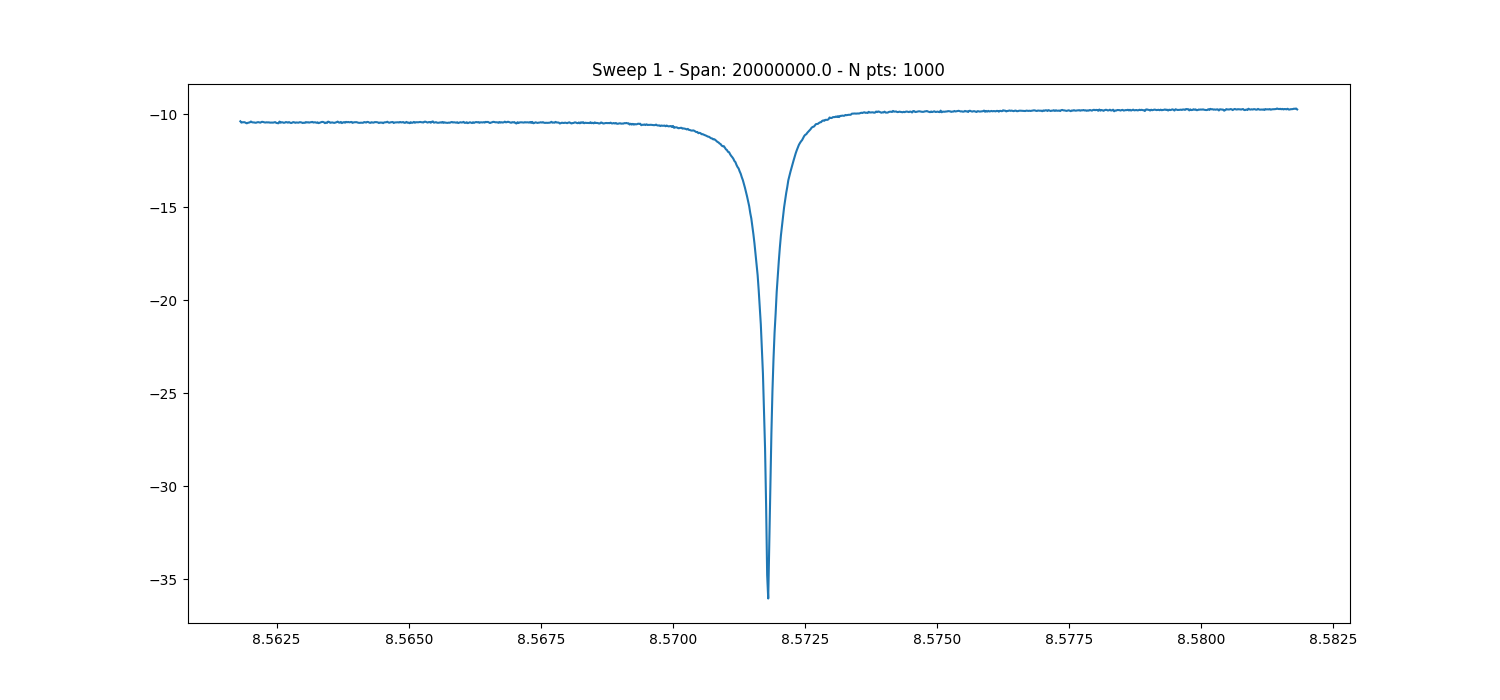

15

In [3]:
sweep = 0

saved_sweep = vna.r_hdf_data(hdf5_file, 'NA_S21', sweep)
I, a, Q, b, f = saved_sweep.values()
amp = np.array(10*np.log10(I**2 + Q**2))
fig = plt.subplots(figsize = (15,7))[0]
plt.clf()
plt.title(f'Sweep {sweep+1} - Span: {b} - N pts: {a}')
plt.plot(f, amp)
plt.show()

def on_key(event):
    global sweep
    global new_data
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    # if (sweep+1) > len(fetched_data):
    #     sweep = 0
    # elif sweep == -1:
    #     sweep = len(fetched_data)-1

    saved_sweep = vna.r_hdf_data(hdf5_file, 'NA_S21', sweep)
    I, a, Q, b, f = saved_sweep.values()
    amp = np.array(10*np.log10(I**2 + Q**2))

    # clear frame
    plt.clf()
    plt.title(f'Sweep {sweep+1} - Span: {b} - N pts: {a}')
    plt.grid()
    plt.plot(f, amp)
    # plt.scatter(x[idx],y[idx], color = 'orange')
    plt.draw() # redraw

fig.canvas.mpl_connect('key_press_event',on_key)



# Fitting

26.73524342568171
Minimum: 16.958130127213483
Maximum: 36.51235672414994
f peak: 8.571796247
Gamma: 8.7513999998734e-05


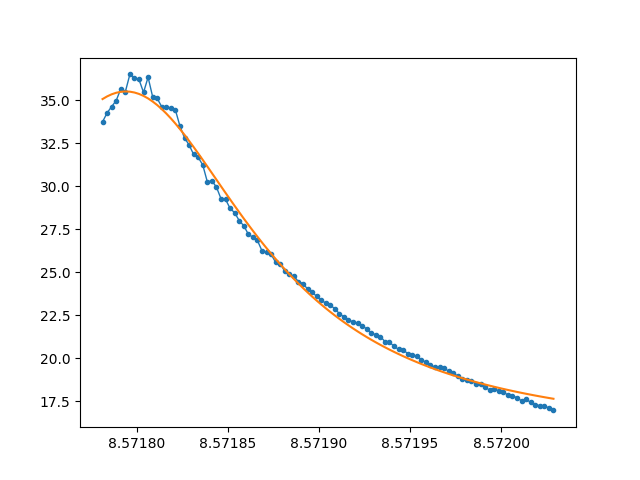

In [15]:
# potenza inviata = -15 dmb
saved_sweep = vna.r_hdf_data(hdf5_file, 'NA_S21', 11)
# print(saved_sweep)
I, a, Q, b, f = saved_sweep.values()

amp = 10*np.log10(I**2 + Q**2) # amplitude

# plt.clf()
# plt.plot(f, amp)
# plt.show()


a_l = a*0.4
a_r = a*0.6
mask = (f < 8.57203) & (f > 8.57178)
y = (-amp[mask]).tolist()
x = f[mask].tolist()

x_c = x
y_c = y

D1_min = min(y)
D1_max = max(y)
idx_max = y.index(max(y))
D1_peak = x[idx_max]

half_height = (D1_max + D1_min)/2
print(half_height)

argMax = np.argmax(y)
idx_L = np.argmin(np.abs(half_height - np.array(y[:argMax])))
idx_R = np.argmin(np.abs(half_height - np.array(y[argMax:]))) + (idx_max + 1)

# fig = plt.figure()
# plt.plot(x, y)
# plt.plot([x[idx_L],x[idx_R]], [y[idx_L],y[idx_R]], ls = 'none', marker = 'o')

D1_gamma = x[idx_R] - x[idx_L]
# plt.show()

print('Minimum:', D1_min)
print('Maximum:', D1_max)
print('f peak:', D1_peak)
print('Gamma:', D1_gamma)

# Amplitude, x0, Gamma, Minimum
pars = [-10, ]
pars = [D1_max, D1_peak, D1_gamma, D1_min]

pars_opt, err_cov = curve_fit(Lorentzian, x, y, pars)
plt.figure()
plt.plot(x_c, y_c, marker = '.', linewidth = 1)   
plt.plot(x_c, Lorentzian(x_c, *pars_opt))